In [1]:
import pandas as pd

In [2]:
data_raw = pd.read_csv('OnlineNewsPopularity .csv')

In [3]:
data_raw.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

In [93]:
#text cleaning
import gensim
from nltk.stem import WordNetLemmatizer

def lemmatize_stemming(text):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(text)
# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

def preprocessToString(text):
    result=""
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result = result + " " + lemmatize_stemming(token)
            
    return result

In [98]:
# find sentiment scores
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def getSentimentScore(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(preprocessToString(text))
    
    return scores
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kaushal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [92]:
#topic modellling

def topicModelling(text):   
    textList = preprocess(text)
    dictionary = gensim.corpora.Dictionary([textList])
    bow_corpus = [dictionary.doc2bow(textList)]
    
    lda_model =  gensim.models.LdaModel(bow_corpus, 
                                   num_topics = 5, 
                                   id2word = dictionary,                                    
                                   passes = 1,
                                   )

    
    return lda_model.print_topics()
    

In [101]:
#named entity recognition
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

def getNER(text):
    tokens = nltk.word_tokenize(preprocessToString(text))
    tagged = nltk.pos_tag(tokens)
    entities = nltk.chunk.ne_chunk(tagged)
    return entities

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kaushal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/kaushal/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/kaushal/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [122]:
#Embeddings using BERT

import torch
import transformers
from transformers import BertTokenizer, BertModel
def getBertEmbedding(text):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    encoded_inputs = tokenizer.tokenize(text)
#     embeddings = model(encoded_inputs)
#     return embeddings
    tokens = tokenizer.tokenize(text)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        embeddings = outputs.last_hidden_state[0]
        
        return (embeddings)


In [120]:
t = 0
for index, row in data_raw.iterrows():
    t+=1
    if t>5:
        break
    topic = row['url'][31:-1]
    print("\n\nArticle heading: ", topic)
    
    print("\nSentiment Scores : ")
    print(getSentimentScore(topic))
    
    print("\nTopic modelling : ")
    print(topicModelling(topic))
    
    print("\nNER :")
    print(getNER(topic))
    
    print("\n BERT encoding :")
    print(getBertEmbedding(topic))
    



Article heading:  amazon-instant-video-browser

Sentiment Scores : 
{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'compound': 0.1779}

Topic modelling : 
[(0, '0.250*"instant" + 0.250*"amazon" + 0.250*"browser" + 0.250*"video"'), (1, '0.250*"amazon" + 0.250*"instant" + 0.250*"video" + 0.250*"browser"'), (2, '0.251*"instant" + 0.250*"video" + 0.250*"amazon" + 0.250*"browser"'), (3, '0.250*"video" + 0.250*"amazon" + 0.250*"instant" + 0.250*"browser"'), (4, '0.250*"browser" + 0.250*"video" + 0.250*"amazon" + 0.250*"instant"')]

NER :
(S amazon/NN instant/JJ video/NN browser/NN)

 BERT encoding :
tensor([[-0.0421,  0.1216, -0.4066,  ..., -0.5184,  0.8614, -0.2209],
        [-0.0991, -0.1116,  0.1205,  ..., -0.3488,  0.6096,  0.0772],
        [-0.1438, -0.0068,  0.3387,  ..., -0.4459,  0.6044,  0.3095],
        ...,
        [ 0.0592,  0.0641,  0.4998,  ..., -0.4815,  0.5164,  0.1958],
        [-0.2229, -0.1702,  0.4197,  ..., -0.3851,  0.6231,  0.0073],
        [ 0.1755,  0.0216,  0.3869,  ...

In [124]:
# Part 2: Correlation Analysis

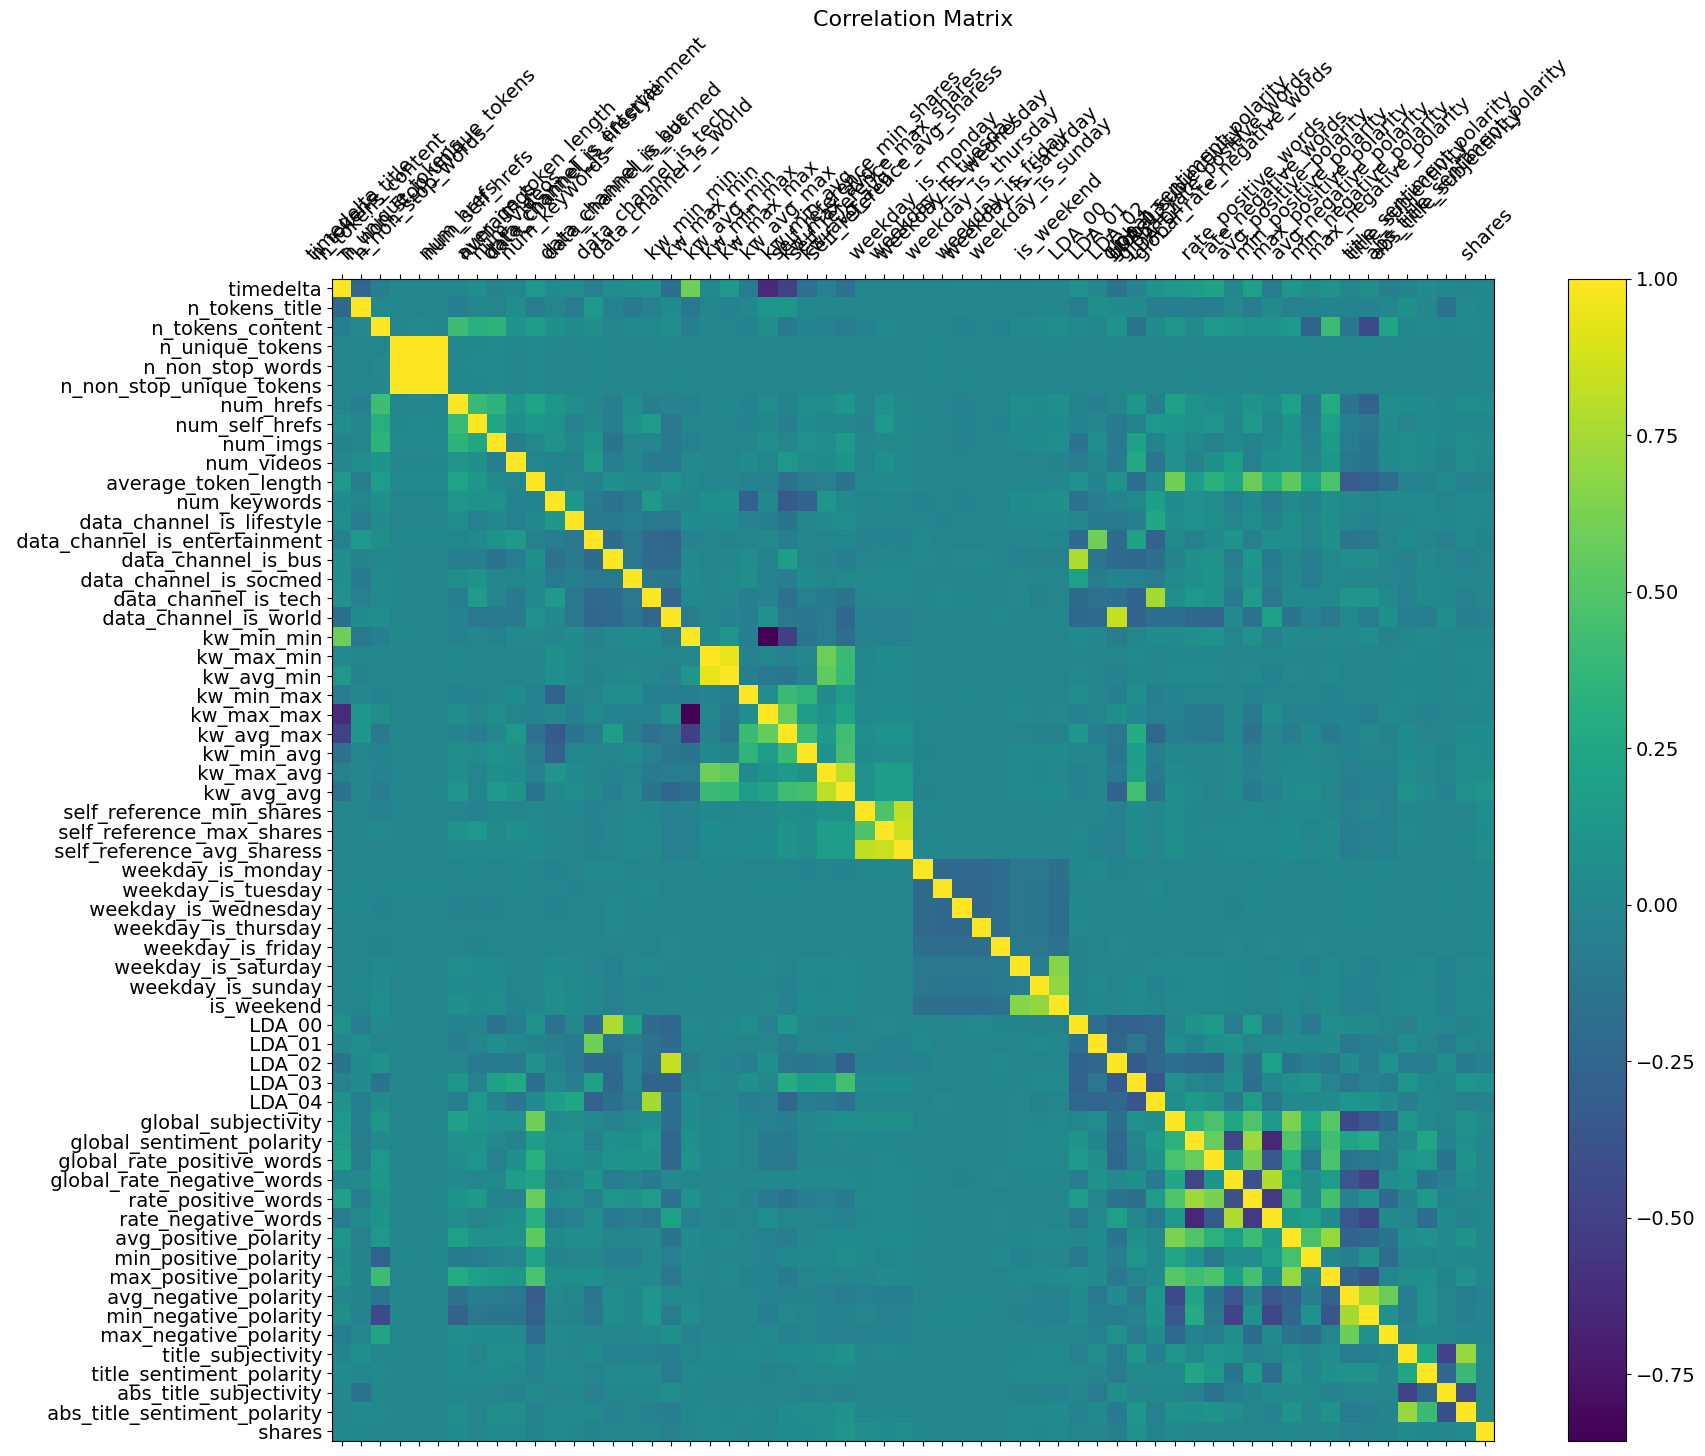

In [121]:
#correlation

import matplotlib.pyplot as plt
neumericDf = data_raw.drop(columns = ['url'])

f = plt.figure(figsize=(19, 15))
plt.matshow(neumericDf.corr(), fignum=f.number)
plt.xticks(range(neumericDf.select_dtypes(['number']).shape[1]), neumericDf.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(neumericDf.select_dtypes(['number']).shape[1]), neumericDf.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [123]:
# Part 3: Predictive Modeling

In [11]:
# Data preparation
from sklearn.model_selection import train_test_split

neumericDf = data_raw.drop(columns = ['url'])
neumericDf.columns

X = neumericDf.drop(columns = [' shares'])
Y = neumericDf[' shares']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
#Linear Regressin

from sklearn.linear_model import LinearRegression
from sklearn import metrics


# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = model.predict(X_test)

# Evaluate the model
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred, squared=False))

# Print the coefficients and intercept
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

Mean Absolute Error: 3007.6896238962236
Mean Squared Error: 117482657.5936954
Root Mean Squared Error: 10838.941719268325
Coefficients: [ 1.77443277e+00  1.44851335e+02  7.97877263e-01  2.82686535e+03
 -2.35915613e+03 -1.29389181e+03  2.54658736e+01 -6.61234920e+01
  5.44975066e+00  7.79195344e+00 -3.14968637e+02  5.36169228e+01
 -1.05608791e+03 -1.23018238e+03 -1.20084272e+03 -6.64191104e+02
 -6.41487073e+02 -4.37770330e+02  4.60405177e-01  1.04631011e-01
 -4.50943315e-01 -2.77216976e-03 -3.30442749e-04  1.74834627e-04
 -3.54949709e-01 -1.99331417e-01  1.61867921e+00  2.29598689e-02
  8.13965877e-03 -1.13812129e-02  3.42380673e+02 -1.79116896e+02
  3.79754417e+00 -2.63098054e+02 -9.59428501e+01  3.32234203e+02
 -1.40255610e+02  1.91978575e+02 -1.32191409e+06 -1.32286484e+06
 -1.32351024e+06 -1.32239164e+06 -1.32245945e+06  2.81702737e+03
  1.68486147e+03 -1.49735601e+04  4.30376888e+03  1.99819175e+03
  2.17396353e+03 -1.61282711e+03 -1.82398433e+03  1.76819908e+02
 -1.27211349e+03  4

In [25]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier(n_estimators = 40, random_state = 42)  

# Fit the model to the training data
model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = model.predict(X_test)

# Evaluate the model
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred, squared=False))

# Print the coefficients and intercept
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

Mean Absolute Error: 2438.818262075924
Mean Squared Error: 124881807.26245429
Root Mean Squared Error: 11175.052897523765


AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

In [18]:
# Neural network
import torch
import torch.nn as nn
import torch.optim as optim

class linearRegression(nn.Module):
    def __init__(self,input_dim):
        super(linearRegression,self).__init__()  
        self.fc1=nn.Linear(input_dim,32) 
        self.fc2=nn.Linear(32,16)
        self.fc3=nn.Linear(16,3)                   
        self.fc4=nn.Linear(3,1)                   

    def forward(self,d):
        out=torch.relu(self.fc1(d))              
        out=torch.relu(self.fc2(out))            
        out=torch.relu(self.fc3(out))            
        out=self.fc4(out)                        
        return out                              

input_dim=X_train.shape[1]
torch.manual_seed(42)  
model=linearRegression(input_dim)

loss=nn.MSELoss() # loss function
optimizers=optim.Adam(params=model.parameters(),lr=0.01)


In [23]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(Y_train.values, dtype=torch.float32)
y_test = torch.tensor(Y_test.values, dtype=torch.float32)

num_of_epochs=10
for i in range(num_of_epochs):    

    y_train_prediction=model(X_train) 
    loss_value=loss(y_train_prediction.squeeze(),y_train)   
    optimizers.zero_grad()
    loss_value.backward()  
    optimizers.step()  

    # print the loss in training part:
    if i % 10 == 0:
        print(f'[epoch:{i}]: The loss value for training part={loss_value}')

TypeError: must be real number, not builtin_function_or_method

In [12]:
X_test

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
32340,121.0,12.0,1015.0,0.422018,1.0,0.545031,10.0,6.0,33.0,1.0,...,0.333534,0.100000,0.80,-0.160714,-0.50,-0.071429,0.0,0.00,0.5,0.00
10480,532.0,9.0,503.0,0.569697,1.0,0.737542,9.0,0.0,1.0,1.0,...,0.419786,0.136364,1.00,-0.157500,-0.25,-0.100000,0.0,0.00,0.5,0.00
15370,435.0,9.0,232.0,0.646018,1.0,0.748428,12.0,3.0,4.0,1.0,...,0.468750,0.375000,0.50,-0.427500,-1.00,-0.187500,0.0,0.00,0.5,0.00
31592,134.0,12.0,171.0,0.722892,1.0,0.867925,9.0,5.0,0.0,1.0,...,0.500000,0.500000,0.50,-0.216667,-0.25,-0.166667,0.4,-0.25,0.1,0.25
198,728.0,11.0,286.0,0.652632,1.0,0.800000,5.0,2.0,0.0,0.0,...,0.303429,0.100000,0.60,-0.251786,-0.50,-0.100000,0.2,-0.10,0.3,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31669,133.0,9.0,342.0,0.504399,1.0,0.634146,7.0,3.0,2.0,0.0,...,0.337734,0.136364,0.80,-0.183333,-0.30,-0.125000,0.0,0.00,0.5,0.00
34677,86.0,8.0,958.0,0.439830,1.0,0.638060,12.0,5.0,1.0,0.0,...,0.321629,0.033333,0.70,-0.218056,-0.40,-0.050000,0.0,0.00,0.5,0.00
15785,427.0,13.0,1153.0,0.427951,1.0,0.631825,6.0,3.0,1.0,2.0,...,0.397023,0.062500,1.00,-0.425621,-1.00,-0.025000,0.0,0.00,0.5,0.00
23738,265.0,9.0,702.0,0.478448,1.0,0.654912,5.0,5.0,0.0,1.0,...,0.387583,0.100000,1.00,-0.305556,-0.50,-0.100000,0.0,0.00,0.5,0.00
